In [1]:
#!pip install folium
#!pip install seaborn
#!pip install haversine
#!pip install tables

In [2]:
import common
import pandas as pd
import haversine as hs
import numpy as np

In [3]:
# Read list.json to pandas dataframe, or load it from a file

df = common.df_from_list('list.json')
df.to_hdf('df.h5', 'df')

#df = pd.read_hdf('df.h5', 'df')

print("sla is starting point latitude, slo is starting point longitude, ela is ending point latitude, elo is ending point longitude")

df

/tmp/ipykernel_198237/2739299476.py:4: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf('df.h5', 'df')


sla is starting point latitude, slo is starting point longitude, ela is ending point latitude, elo is ending point longitude


,datetime,duration_minutes,sla,slo,ela,elo
0,2023-01-03 12:11:00,9.650000,49.197684,16.640210,49.189396,16.617106
1,2023-01-03 17:57:55,11.550000,49.189396,16.617106,49.201914,16.641787
2,2023-01-04 11:48:46,10.550000,49.201914,16.641787,49.191415,16.619807
3,2023-01-04 17:53:59,12.533333,49.189396,16.617106,49.201914,16.641787
4,2023-01-09 11:49:58,11.033333,49.201914,16.641787,49.191415,16.619807
...,...,...,...,...,...,...
415,2024-05-10 16:42:14,13.950000,49.196597,16.608866,49.223585,16.597762
416,2024-05-10 17:49:07,14.000000,49.220446,16.596705,49.196597,16.608866
417,2024-05-10 19:40:23,14.400000,49.196004,16.615046,49.195861,16.650252
418,2024-05-14 17:09:57,10.383333,49.196597,16.608866,49.217362,16.607707


In [4]:
pd.set_option('display.precision', 2)

# Calulate distance between start and end location

# we use haversine package to calculate the distance between two points
df['distance_km'] = df.apply(lambda x: hs.haversine((x['sla'], x['slo']), (x['ela'], x['elo']), unit=hs.Unit.KILOMETERS), axis=1)

# I measured that travel distance is approximately 1.25 times the aerial distance
df['real_distance_km'] = df.distance_km * 1.25


# Cleanup

# I never drive more than 50 km on nextbike, anything so high is an error
df = df[df.distance_km < 50]
df = df[df.distance_km > 0]

# I never spent more than 2 hours on nextbike
df = df[df.duration_minutes < 120]

df

,datetime,duration_minutes,sla,slo,ela,elo,distance_km,real_distance_km
0,2023-01-03 12:11:00,9.65,49.20,16.64,49.19,16.62,1.92,2.39
1,2023-01-03 17:57:55,11.55,49.19,16.62,49.20,16.64,2.27,2.84
2,2023-01-04 11:48:46,10.55,49.20,16.64,49.19,16.62,1.98,2.47
3,2023-01-04 17:53:59,12.53,49.19,16.62,49.20,16.64,2.27,2.84
4,2023-01-09 11:49:58,11.03,49.20,16.64,49.19,16.62,1.98,2.47
...,...,...,...,...,...,...,...,...
415,2024-05-10 16:42:14,13.95,49.20,16.61,49.22,16.60,3.11,3.88
416,2024-05-10 17:49:07,14.00,49.22,16.60,49.20,16.61,2.80,3.49
417,2024-05-10 19:40:23,14.40,49.20,16.62,49.20,16.65,2.56,3.20
418,2024-05-14 17:09:57,10.38,49.20,16.61,49.22,16.61,2.31,2.89


Text(0.5, 0, 'Trip length (km)')

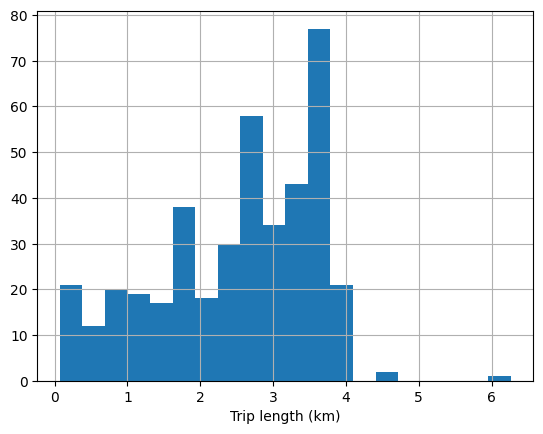

In [5]:
# how long trips I have taken

ax = df.real_distance_km.hist(bins=20)
ax.set_xlabel("Trip length (km)")

The histogram above shows that I mostly ride trips around 3-4 km. Rarely more than that, and less than 2 km is usually OK to walk.

There are peaks - those are routes that I take more often, probably commuting route.

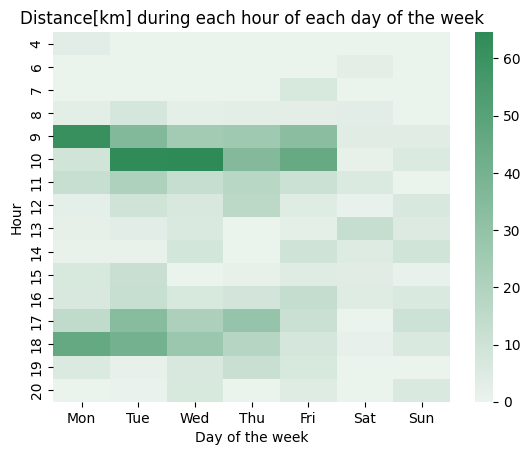

In [14]:
# heatgrid to show when I have taken trips

import seaborn as sns
import matplotlib.pyplot as plt

weekday_list = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

heat_df = df[['datetime', 'real_distance_km']].copy()
heat_df['Day of the week'] = pd.Categorical(heat_df.datetime.dt.day_of_week.map(lambda x: weekday_list[x]),
                                             categories=weekday_list, ordered=True)
heat_df['Hour'] = heat_df.datetime.dt.hour


sns.heatmap(
    heat_df.pivot_table(index='Hour', columns='Day of the week', values='real_distance_km', aggfunc='sum', observed=False),
    cmap=sns.light_palette("seagreen", as_cmap=True))
plt.title("Distance[km] during each hour of each day of the week")
plt.savefig('time.png')
plt.show()


I mostly ride nextbike at 9 or 10 in the morning and then 17 or 18 in the evening during weekdays.

In [7]:
# Print general stats about my rides


print("Total distance travelled:  %.2f km" % df.real_distance_km.sum())
print("Total time spent: %.2f" % (df.duration_minutes.sum() / 60), "hours")
print("Total trips:", df.shape[0])

Total distance travelled:  1047.56 km
Total time spent: 77.37 hours
Total trips: 411


In [8]:
# Print monthly aggregated stats

month_agg = common.time_agg(df, 'M', "%Y-%m")
month_agg.index.rename('month', inplace=True)
month_agg['duration_hours'] = pd.to_datetime(month_agg.duration_minutes, unit='m').dt.strftime('%H:%M')
month_agg['speed_kmph'] = month_agg.real_distance_km/(month_agg.duration_minutes/60)

month_agg.drop('duration_minutes', axis=1, inplace=True)


month_agg

/home/tomk/nb/common.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  res_agg = indf.groupby(pd.Grouper(key="datetime", freq=freq)).agg(


,real_distance_km,trips,duration_hours,speed_kmph
month,,,,
2023-01,78.54,33,05:53,13.32
2023-02,55.93,32,04:48,11.63
2023-03,69.04,44,05:17,13.04
2023-04,52.82,25,03:50,13.73
2023-05,63.83,29,04:47,13.31
2023-06,12.62,6,00:52,14.38
2023-09,50.36,17,03:39,13.79
2023-10,97.13,33,06:44,14.41
2023-11,119.47,37,08:40,13.78


In [9]:
# Print daily averages

day_agg = common.time_agg(df, 'D', "%Y-%m-%d")
day_agg.index.rename('date', inplace=True)
day_agg['speed_kmph'] = day_agg.real_distance_km / (day_agg.duration_minutes/60)

print("Average distance per day: %.2f km" % day_agg.real_distance_km.mean())
print("Average number of trips per day: %.2f" % day_agg.trips.mean())
print("Average time spent on bike per day: %.2f minutes" % day_agg.duration_minutes.mean())
day_agg


Average distance per day: 4.57 km
Average number of trips per day: 1.79
Average time spent on bike per day: 20.27 minutes


,real_distance_km,duration_minutes,trips,speed_kmph
date,,,,
2023-01-03,5.23,21.20,2,14.81
2023-01-04,5.31,23.08,2,13.80
2023-01-09,5.31,24.05,2,13.25
2023-01-10,4.01,18.05,2,13.33
2023-01-11,5.88,26.72,3,13.21
...,...,...,...,...
2024-05-08,1.78,11.53,1,9.29
2024-05-09,5.33,34.38,2,9.31
2024-05-10,16.79,78.67,6,12.81


In [10]:
import folium
import pandas as pd

tiles = 'https://tiles.stadiamaps.com/tiles/stamen_toner/{z}/{x}/{y}@2x.png?api_key=e014ecc6-b337-46f2-894e-84d0e652821d'
attr = "stamen Toner"
m = folium.Map(tiles = tiles, attr=attr) 
def create_map(points,w=1, o=0.1):
    coordinates = []
    for p in points:
       coordinates.append(p[0])
       coordinates.append(p[1])
    folium.PolyLine(points,color = 'red',  weight=w, opacity=o).add_to(m)
    df = pd.DataFrame(coordinates).rename(columns={0:'Lat', 1:'Lon'})[['Lat', 'Lon']]
    sw = df[['Lat', 'Lon']].min().values.tolist()
    ne = df[['Lat', 'Lon']].max().values.tolist()
    m.fit_bounds([sw, ne])
    return m

In [11]:
# get (start, end) location tuples
lines = [((i.sla, i.slo), (i.ela, i.elo)) for i in df.itertuples()]

# get bezier curves so that we can se 
arclines = [common.interpolate_arc(i[0][0], i[0][1], i[1][0], i[1][1], 30) for i in lines]

In [12]:

mymap = create_map(arclines,1,.4)
mymap

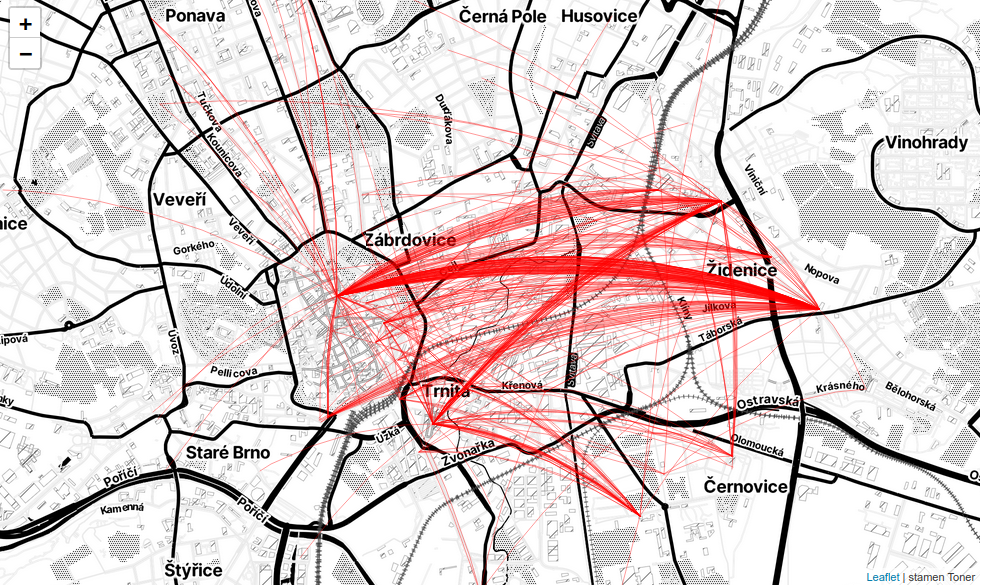

In [13]:
# The map looks more or less like this

from IPython.display import Image
Image(filename='map.png') 